### Anomaly Detection
- To indentify the data points that are different of the other data point
- There are 3 categories
    - Supervised Anomaly Dection: labels for both nomal and anomalous data
    - Semi-Supervised Anomaly Dectection: only label of nomal data 
    - Unsupervise Anomaly Dectection: no label is available
- Algorithms
    - Mahalanobis Distance: 
        - For one single dimension data, z-score can be used for outlier/anomaly detection. A data point is labeled as an anomaly if |z| > T (Threshold)
        - For multidimensional data, the z-score is not applicable. The Mahalanobis distance defined as https://en.wikipedia.org/wiki/Mahalanobis_distance
        
    - Density-based spatial clustering of application with noise (DBSCAN)
        - Find neighbors of all points of redius - Redius of defining neighborhood
        - Indentify a core point minimum number of datapoints required for formimng a local cluster
        - Find  the connected components of core point on the neighbors graph
        - Assign each non-core point to a nearby cluster if the cluster is an Redius of defining neighborhood, otherwise assign it to noise
    - Local Outlier Factor (LOF)
    - Isolation Forest
    - One-Class Support Vector Machine

In [127]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make dataset
from sklearn.datasets import make_blobs

# statistical modules for data generation and critical values
from scipy.stats import multivariate_normal, beta, uniform, t

from functools import partial

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.covariance import EllipticEnvelope # use for Mohalanobis distance
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from typing import Any


In [128]:
class DBSCAND_outliner(DBSCAN):

    def __init__(self, eps = 0.5, *, min_samples = 5, metric = "euclidean", metric_params = None, algorithm = "auto", leaf_size = 30, p = None, n_jobs = None) -> None:
        super().__init__(eps, min_samples = min_samples, metric = metric, metric_params = metric_params, algorithm = algorithm, leaf_size = leaf_size, p = p, n_jobs = n_jobs)
        self._estimator_type = "outlier_detector"
        self._nbrs = NearestNeighbors(n_neighbors = 2)

    def fit_predict(self, X, y: Any = None) -> np.ndarray:
        labels = super().fit_predict(X, y, sample_weight = None)
        labels[labels > -1] = 1 # convert any non-negative cluster index to 1
        self._nbrs.fit(X = X[labels])
        return labels
    
    def fit(self, X, y = None, sample_weight = None):
        self._X = X # memorize the training samples
        super().fit(X = X)
        self._nbrs.fit(X = X[self.labels_ > -1])
        return self
    
    def decision_function(self, X):
        min_distance, _s = self._nbrs.kneighbors(X = X, n_neighbors = 1)
        scores = -min_distance[:, 0] + self.eps 
        return scores
    
    def predict(self, X):
        scores = self.decision_function(X)
        labels = np.zeros_like(scores, 'int')
        labels[scores >= 0] = 1
        labels[scores < 0] = -1
        return labels

In [129]:
# test 

eps = 1
min_points = 5

clf_dbscan = DBSCAN(eps = eps, min_samples = min_points)
clf_dbscan

DBSCAN(eps=1)

In [130]:
# create a dataset that have points from a single multivariate Gaussion population, then manuallu add a outlier into a dataset

np.random.seed(0) # random seed = 0
n = 1000 # 1000 samples
mu = np.array([0, 0]) # zero means
sigma = np.array([
    [2, 1],
    [1, 2]
])
normal = multivariate_normal.rvs(mean = mu, cov = sigma, size = n) # rvs: random variates of size (size, N), where N is the dimension of the random variable
normal

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-0.31140929, -0.17316878],
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187]])

In [131]:
len(normal)

1000

Text(0.5, 1.0, 'Unimodal Data with Single Anomaly')

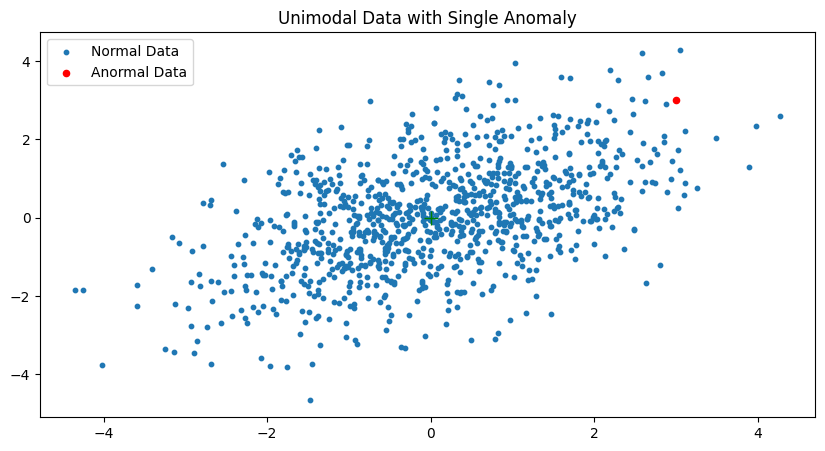

In [132]:
anomaly = np.array([3, 3])
anomaly = np.array([3, 3]).reshape(-1, 2) # anomaly data popint

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')
ax.plot([0], [0], marker = '+', color = 'green', markersize = 10) # mark the center
ax.scatter(anomaly[:, 0], anomaly[:, 1], s = 20, color = 'red', label = 'Anormal Data') # add anomaly data point

ax.legend()
ax.set_title('Unimodal Data with Single Anomaly')

In [133]:
# concate normal and anomaly together

dataset1 = np.concatenate((normal, anomaly)) # last item is the anomaly
dataset1

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187],
       [ 3.        ,  3.        ]])

In [134]:
# create labels: 0 for nomal, 1 for anomaly

label = np.concatenate([(np.zeros(n, )), np.ones(1, )])  # last item is the anomaly
label

array([0., 0., 0., ..., 0., 0., 1.])

In [135]:
len(label)

1001

In [136]:
# set params: elbow point (eps) must be larger enough to cover data points, min_points should be at least larger than the dimension of dataset +1

min_points = 3

nbrs = NearestNeighbors(n_neighbors = min_points)
nbrs.fit(X = dataset1) # train/fit
distances, index = nbrs.kneighbors(X = dataset1, n_neighbors = 2)

In [137]:
distances

array([[0.        , 0.08461608],
       [0.        , 0.10756274],
       [0.        , 0.32648974],
       ...,
       [0.        , 0.01308561],
       [0.        , 0.09669892],
       [0.        , 0.14916401]])

In [138]:
index

array([[   0,  724],
       [   1,  421],
       [   2,  512],
       ...,
       [ 998,  569],
       [ 999,  602],
       [1000,  278]])

In [139]:
distances2 = np.sort(distances, axis = 0)
distances2

array([[0.        , 0.00234166],
       [0.        , 0.00234166],
       [0.        , 0.00478677],
       ...,
       [0.        , 0.83848187],
       [0.        , 0.86345649],
       [0.        , 0.88363232]])

In [140]:
distances2 = distances2[: -1]
distances2

array([[0.        , 0.00234166],
       [0.        , 0.00234166],
       [0.        , 0.00478677],
       ...,
       [0.        , 0.61427748],
       [0.        , 0.83848187],
       [0.        , 0.86345649]])

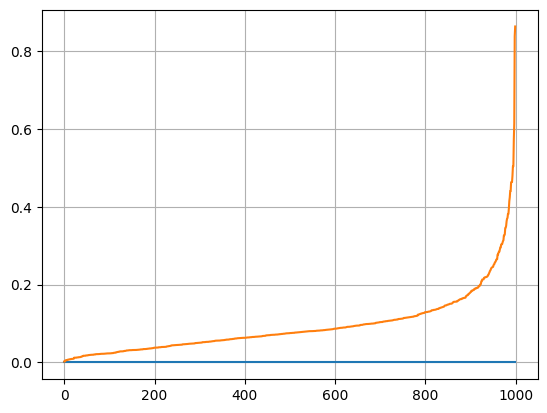

In [141]:
plt.plot(distances2)
plt.grid()

In [142]:
# refered to above graph, we can see the elbow point at maximum curvature is reounf 0.25

eps = 1
min_points = 3

In [143]:
clf_dbscan = DBSCAND_outliner(eps = eps, min_samples = min_points)
clf_dbscan

DBSCAND_outliner(eps=1, min_samples=3)

In [144]:
# fit/train model

clf_dbscan.fit(dataset1)

DBSCAND_outliner(eps=1, min_samples=3)

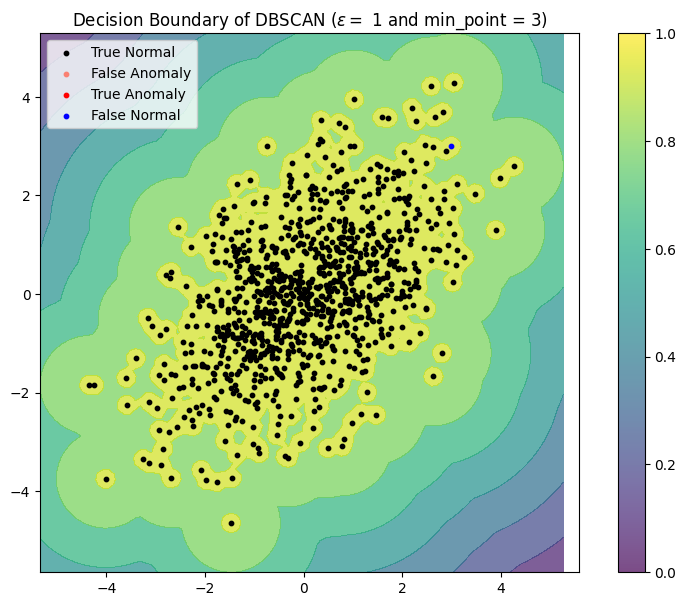

In [145]:
# Decision boundary and anomaly output

dataset = dataset1
normal_data = normal
anomaly_data = anomaly

# plot

fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_dbscan, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_dbscan.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_dbscan.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of DBSCAN ($\varepsilon=$ {} and min_point = {})".format(eps, min_points))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [146]:
# Performance evaluation

pred = clf_dbscan.predict(dataset1)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of DBSCAN Anomaly Detection Algorithm")
print(classification_report(label, pred, target_names = target_names))

Classification Report of DBSCAN Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       1.00      1.00      1.00      1000
     Anomaly       0.00      0.00      0.00         1

    accuracy                           1.00      1001
   macro avg       0.50      0.50      0.50      1001
weighted avg       1.00      1.00      1.00      1001



/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/conda_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [148]:
# Unimodal data surrounded by Anomalies
# create a dataset which the data points are derived from a single multivariate Gaussian population. Oulier are added as the extreme outlier.

np.random.seed(0) # set for consistance run
n = 10_000
n

10000

In [149]:
n_normal = int(n * 0.98)
n_normal

9800

In [150]:
n_anomaly = n - n_normal
n_anomaly

200

In [151]:
normal2, _ = make_blobs(n_samples = n_normal, n_features = 2, centers = [[0, 0]], cluster_std = [1.0])
normal2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 0.94327374,  0.30047837],
       [ 0.04968522, -1.60184875],
       [-1.18709247,  0.65935716]])

In [152]:
len(normal2)

9800

In [153]:
# anomalies are located on the circle of radius r = 4 centered at the origin
 
r = 4
theta = np.arange(n_anomaly) * (2 * np.pi * n_anomaly) # 2% anomaly rate
theta

array([     0.        ,   1256.63706144,   2513.27412287,   3769.91118431,
         5026.54824574,   6283.18530718,   7539.82236862,   8796.45943005,
        10053.09649149,  11309.73355292,  12566.37061436,  13823.0076758 ,
        15079.64473723,  16336.28179867,  17592.9188601 ,  18849.55592154,
        20106.19298297,  21362.83004441,  22619.46710585,  23876.10416728,
        25132.74122872,  26389.37829015,  27646.01535159,  28902.65241303,
        30159.28947446,  31415.9265359 ,  32672.56359733,  33929.20065877,
        35185.83772021,  36442.47478164,  37699.11184308,  38955.74890451,
        40212.38596595,  41469.02302739,  42725.66008882,  43982.29715026,
        45238.93421169,  46495.57127313,  47752.20833456,  49008.845396  ,
        50265.48245744,  51522.11951887,  52778.75658031,  54035.39364174,
        55292.03070318,  56548.66776462,  57805.30482605,  59061.94188749,
        60318.57894892,  61575.21601036,  62831.8530718 ,  64088.49013323,
        65345.12719467,  

In [155]:
len(theta), type(theta)

(200, numpy.ndarray)

In [156]:
x = np.cos(theta) * r + np.random.randn(n_anomaly) * r * 0.1
x

array([4.13824916, 3.86209803, 3.91090796, 3.15698466, 3.48906472,
       3.98200253, 4.49630777, 3.78520134, 3.75997755, 3.94043495,
       3.64156799, 3.68919321, 3.86324671, 4.03288218, 3.86461181,
       3.57331502, 4.20043556, 4.36841824, 3.97690262, 3.71805384,
       4.51583389, 4.05435159, 3.8484569 , 3.66020798, 4.44906376,
       4.31800552, 4.24419883, 4.21461297, 3.92152417, 3.52482017,
       3.53205322, 3.77134917, 4.26828343, 4.09751009, 3.22297486,
       4.38929806, 4.02417454, 3.57583833, 4.40610443, 3.58453322,
       4.52878889, 4.07839154, 3.67697688, 3.42537398, 4.7922005 ,
       3.7081905 , 4.40763529, 3.07682376, 4.52112761, 3.85696596,
       4.07350707, 3.8835773 , 4.38965104, 4.33158797, 4.11820714,
       4.03774096, 3.55711867, 3.68175037, 3.62237363, 4.15689317,
       3.6257309 , 4.02811074, 3.48329757, 4.003898  , 3.64754184,
       4.38115689, 3.97226408, 3.63172419, 4.33083697, 4.4628217 ,
       4.15928518, 4.43082953, 3.71974069, 3.97610658, 4.13131

In [157]:
len(x)

200

In [158]:
y = np.sin(theta) * r + np.random.randn(n_anomaly) * r * 0.1
y

array([-0.7484382 , -0.06345132, -0.0324438 , -0.38272528, -0.23739723,
        0.6504494 , -0.11917175,  0.05130609,  0.38713665,  0.12574708,
       -0.110413  ,  0.10834949,  0.08734993,  0.1984614 , -0.03478346,
        0.65298901, -0.6562069 , -1.18765655,  0.53401657,  0.34781761,
       -0.076691  ,  0.16932873,  0.95066974, -0.27267265, -0.56449135,
       -0.56489535, -0.31702201, -0.05400069, -0.53660312, -0.32749463,
       -0.47702724, -0.01844818, -0.02428687,  0.10261947,  0.07018698,
        0.52185801, -0.48134485, -0.65163092,  0.05181227, -0.12425454,
       -0.17290319,  0.56461834, -0.0099415 ,  0.19555729,  0.58928546,
       -0.37058196, -0.23489665, -0.09319964,  0.67289334, -0.8022579 ,
        0.47374182, -0.06368523,  0.38707474, -1.05389026,  0.44764915,
        0.1599077 ,  0.85317581,  0.42061626, -0.25958429, -0.06026753,
       -0.0089972 , -0.39973904, -0.32199238,  0.40928928,  0.00688129,
       -0.22244326, -1.05574711,  0.47097882, -1.02697921,  0.34

In [159]:
len(y)

200

In [160]:
anomaly2 = np.stack((x, y), axis = 0)
anomaly2

array([[ 4.13824916e+00,  3.86209803e+00,  3.91090796e+00,
         3.15698466e+00,  3.48906472e+00,  3.98200253e+00,
         4.49630777e+00,  3.78520134e+00,  3.75997755e+00,
         3.94043495e+00,  3.64156799e+00,  3.68919321e+00,
         3.86324671e+00,  4.03288218e+00,  3.86461181e+00,
         3.57331502e+00,  4.20043556e+00,  4.36841824e+00,
         3.97690262e+00,  3.71805384e+00,  4.51583389e+00,
         4.05435159e+00,  3.84845690e+00,  3.66020798e+00,
         4.44906376e+00,  4.31800552e+00,  4.24419883e+00,
         4.21461297e+00,  3.92152417e+00,  3.52482017e+00,
         3.53205322e+00,  3.77134917e+00,  4.26828343e+00,
         4.09751009e+00,  3.22297486e+00,  4.38929806e+00,
         4.02417454e+00,  3.57583833e+00,  4.40610443e+00,
         3.58453322e+00,  4.52878889e+00,  4.07839154e+00,
         3.67697688e+00,  3.42537398e+00,  4.79220050e+00,
         3.70819050e+00,  4.40763529e+00,  3.07682376e+00,
         4.52112761e+00,  3.85696596e+00,  4.07350707e+0

In [161]:
len(anomaly2)

2

In [162]:
anomaly2.shape

(2, 200)

In [163]:
anomaly2 = np.stack((x, y), axis = 0).T
anomaly2

array([[ 4.13824916e+00, -7.48438196e-01],
       [ 3.86209803e+00, -6.34513221e-02],
       [ 3.91090796e+00, -3.24437993e-02],
       [ 3.15698466e+00, -3.82725275e-01],
       [ 3.48906472e+00, -2.37397226e-01],
       [ 3.98200253e+00,  6.50449400e-01],
       [ 4.49630777e+00, -1.19171750e-01],
       [ 3.78520134e+00,  5.13060913e-02],
       [ 3.75997755e+00,  3.87136651e-01],
       [ 3.94043495e+00,  1.25747077e-01],
       [ 3.64156799e+00, -1.10413001e-01],
       [ 3.68919321e+00,  1.08349488e-01],
       [ 3.86324671e+00,  8.73499315e-02],
       [ 4.03288218e+00,  1.98461405e-01],
       [ 3.86461181e+00, -3.47834627e-02],
       [ 3.57331502e+00,  6.52989012e-01],
       [ 4.20043556e+00, -6.56206898e-01],
       [ 4.36841824e+00, -1.18765655e+00],
       [ 3.97690262e+00,  5.34016570e-01],
       [ 3.71805384e+00,  3.47817609e-01],
       [ 4.51583389e+00, -7.66910040e-02],
       [ 4.05435159e+00,  1.69328725e-01],
       [ 3.84845690e+00,  9.50669739e-01],
       [ 3.

In [164]:
len(anomaly2)

200

In [165]:
anomaly2.shape

(200, 2)

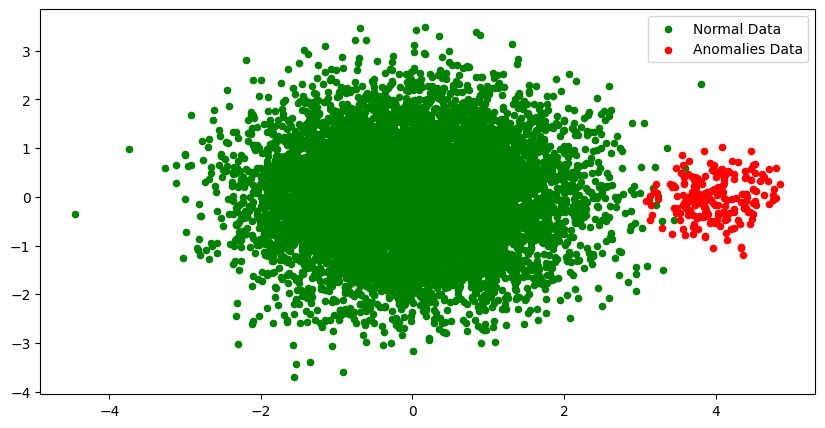

In [166]:
# plot

plt.figure(figsize = (10, 5))
plt.scatter(normal2[:, 0], normal2[:, 1], s = 20, color = 'green', label = 'Normal Data')
plt.scatter(anomaly2[:, 0], anomaly2[:, 1], s = 20, color = 'red', label = 'Anomalies Data')
plt.legend();

In [167]:
# concate nomal and anomalies data

dataset2 = np.concatenate((normal2, anomaly2))
dataset2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 4.48989903,  0.16155138],
       [ 3.48682331,  0.01510058],
       [ 3.87422017, -0.26189921]])

In [168]:
len(dataset2)

10000

In [169]:
label2 = np.concatenate([(np.zeros(n_normal, )), np.ones(n_anomaly, )]) # labeled data by setting 0 for normal and 1 for anomaly
label2

array([0., 0., 0., ..., 1., 1., 1.])

In [170]:
len(label2)

10000

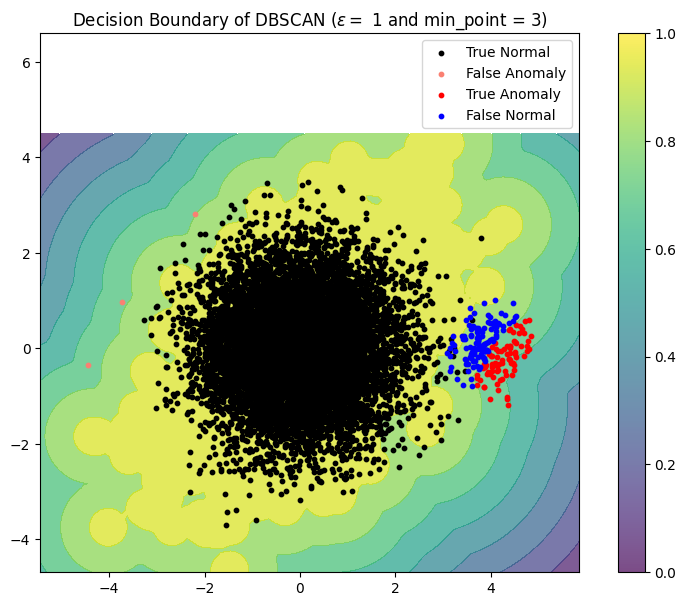

In [172]:
# Decision boundary and anomaly output

dataset = dataset2
normal_data = normal2
anomaly_data = anomaly2

# plot

fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_dbscan, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_dbscan.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_dbscan.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of DBSCAN ($\varepsilon=$ {} and min_point = {})".format(eps, min_points))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [175]:
# Performance evaluation

pred = clf_dbscan.predict(dataset2)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of DBSCAN Anomaly Detection Algorithm")
print(classification_report(label2, pred, target_names = target_names))

Classification Report of DBSCAN Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       0.99      1.00      0.99      9800
     Anomaly       0.97      0.42      0.59       200

    accuracy                           0.99     10000
   macro avg       0.98      0.71      0.79     10000
weighted avg       0.99      0.99      0.99     10000



In [176]:
# ROC

scores = -clf_dbscan.decision_function(dataset2)
scores

array([-0.90972424, -0.96006973, -0.93754416, ...,  0.28095639,
       -0.4852882 , -0.01259571])

In [177]:
len(scores)

10000

In [178]:
fpr, tpr, _ = roc_curve(y_true = label2, y_score = scores, pos_label = 1)
fpr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.02040816e-04,
       1.02040816e-04, 2.04081633e-04, 2.04081633e-04, 3.06122449e-04,
       3.06122449e-04, 4.08163265e-04, 4.08163265e-04, 5.10204082e-04,
       5.10204082e-04, 6.12244898e-04, 6.12244898e-04, 7.14285714e-04,
       7.14285714e-04, 8.16326531e-04, 8.16326531e-04, 9.18367347e-04,
       9.18367347e-04, 1.02040816e-03, 1.02040816e-03, 1.12244898e-03,
       1.12244898e-03, 1.32653061e-03, 1.32653061e-03, 1.53061224e-03,
       1.53061224e-03, 1.93877551e-03, 1.93877551e-03, 2.14285714e-03,
       2.14285714e-03, 2.65306122e-03, 2.65306122e-03, 3.26530612e-03,
       3.26530612e-03, 4.08163265e-03, 4.08163265e-03, 4.28571429e-03,
       4.28571429e-03, 4.89795918e-03, 4.89795918e-03, 5.91836735e-03,
       5.91836735e-03, 6.42857143e-03, 6.42857143e-03, 7.44897959e-03,
       7.44897959e-03, 7.55102041e-03, 7.55102041e-03, 8.06122449e-03,
       8.06122449e-03, 9.08163265e-03, 9.08163265e-03, 1.01020408e-02,
      

In [179]:
tpr

array([0.   , 0.005, 0.2  , 0.2  , 0.305, 0.305, 0.39 , 0.39 , 0.615,
       0.615, 0.625, 0.625, 0.66 , 0.66 , 0.67 , 0.67 , 0.77 , 0.77 ,
       0.78 , 0.78 , 0.83 , 0.83 , 0.845, 0.845, 0.855, 0.855, 0.86 ,
       0.86 , 0.87 , 0.87 , 0.88 , 0.88 , 0.89 , 0.89 , 0.895, 0.895,
       0.9  , 0.9  , 0.905, 0.905, 0.91 , 0.91 , 0.915, 0.915, 0.925,
       0.925, 0.93 , 0.93 , 0.935, 0.935, 0.945, 0.945, 0.95 , 0.95 ,
       0.955, 0.955, 0.96 , 0.96 , 0.965, 0.965, 0.97 , 0.97 , 0.975,
       0.975, 0.98 , 0.98 , 0.985, 0.985, 0.99 , 0.99 , 0.995, 0.995,
       1.   , 1.   ])

In [180]:
_

array([ 1.65755576,  0.65755576,  0.29151787,  0.29049594,  0.14064529,
        0.12293381,  0.02446269,  0.01635584, -0.15269532, -0.15591408,
       -0.15785297, -0.16480986, -0.20902425, -0.21075972, -0.22048107,
       -0.2396678 , -0.30063863, -0.30733894, -0.31096527, -0.31370349,
       -0.33522419, -0.33999035, -0.35018055, -0.35983287, -0.3691348 ,
       -0.37577724, -0.38411821, -0.38945995, -0.39213408, -0.41326152,
       -0.42564149, -0.4278237 , -0.44011434, -0.46505745, -0.46668701,
       -0.48361422, -0.4852882 , -0.52426212, -0.52592756, -0.53677628,
       -0.53706755, -0.55510911, -0.56289453, -0.57853168, -0.58594683,
       -0.5957993 , -0.59586713, -0.61242286, -0.61655424, -0.61780308,
       -0.62262194, -0.63046055, -0.6322603 , -0.64787375, -0.64948866,
       -0.65783971, -0.66029915, -0.66201833, -0.66298709, -0.67220247,
       -0.67446768, -0.68798941, -0.68825396, -0.72807969, -0.72818651,
       -0.73733767, -0.73840988, -0.74326364, -0.74382783, -0.79

In [181]:
auc_score = auc(fpr, tpr)
auc_score

0.9983612244897959

[]

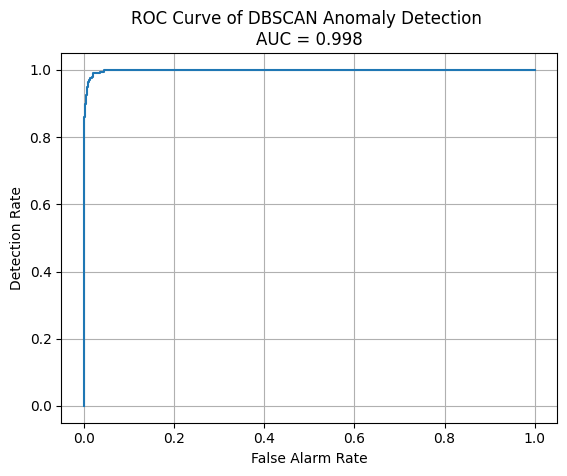

In [182]:
plt.plot(fpr, tpr)
plt.title(f"ROC Curve of DBSCAN Anomaly Detection \nAUC = {auc_score:0.3f}")
plt.grid()
plt.xlabel("False Alarm Rate")
plt.ylabel("Detection Rate")
plt.plot()